Тут мы решили посмотреть насколько лучше стало качество генерации у новой модели SDXL ([sd_xl_base_1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0)) по сравнению с [SD2](512-base-ema (https://huggingface.co/stabilityai/stable-diffusion-2-base)). Конечно вариантов Stable Diffusion моделей уже есть большое множество, и каждая затюнина под своё, но мы специально брали стоковую для сравнения.

Установим `diffusers` версии >= 0.19.0:

In [1]:
!pip install diffusers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.2 MB/s eta 0:00:00


Кроме того, обязательно установите `transformers`, `safetensors`, `accelerate`, а также `invisible watermark`:

In [2]:
!pip install invisible_watermark transformers accelerate safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.3 MB/s eta 0:00:00


Чтобы просто использовать базовую модель, вы можете запустить:

In [ ]:
import torch
from diffusers import DiffusionPipeline




pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
                                         torch_dtype=torch.float16,
                                         use_safetensors=True,
                                         variant="fp16")
pipe.to("cuda")
# If you are limited by GPU VRAM, you can enable cpu offloading by calling pipe.enable_model_cpu_offload instead of .to("cuda"):
#pipe.enable_model_cpu_offload()


#When using torch >= 2.0, you can improve the inference speed by 20-30% with torch.compile.
#torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

# if using torch < 2.0
# pipe.enable_xformers_memory_efficient_attention()

prompt = "A majestic lion jumping from a big stone at night"

images = pipe(prompt=prompt).images[0]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

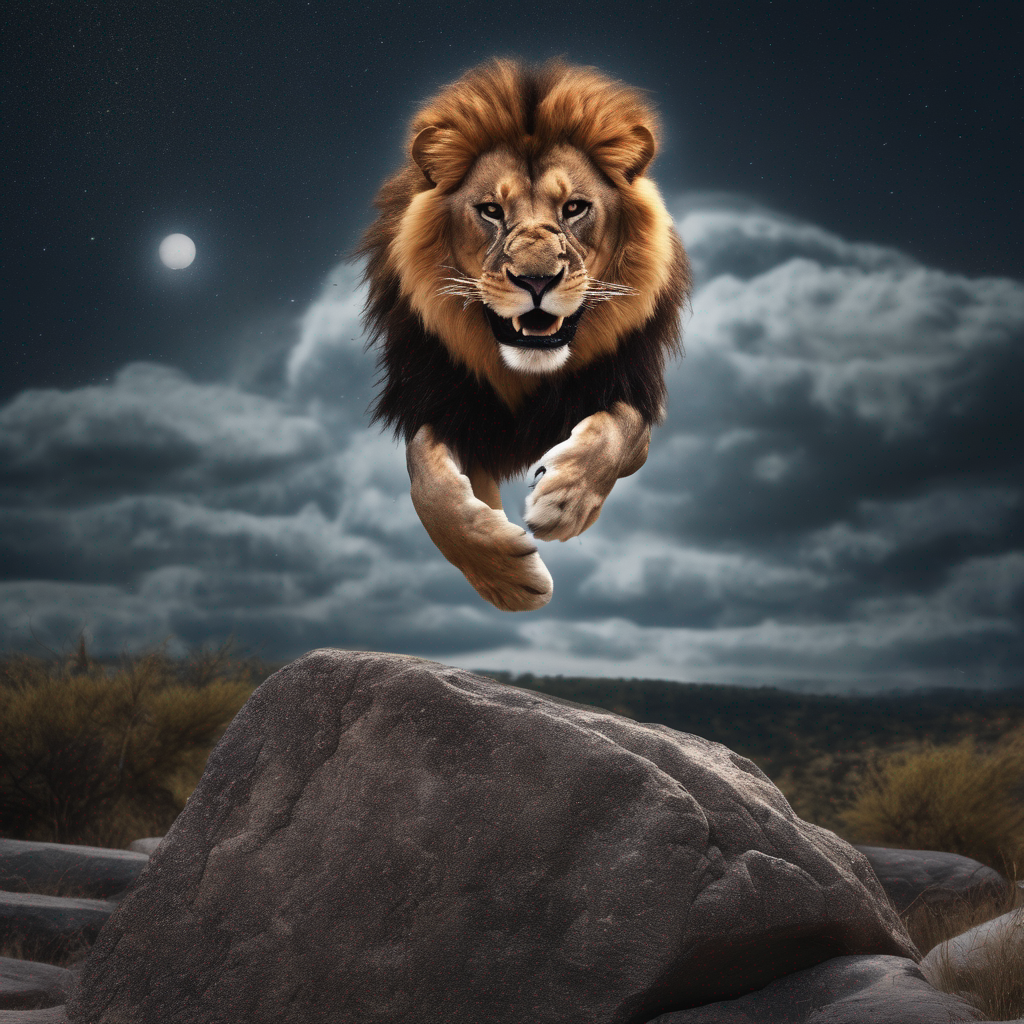

In [ ]:
images

Добавим негативный промпт, количество шагов, sampler, назмер выходного изображения

  0%|          | 0/100 [00:00<?, ?it/s]

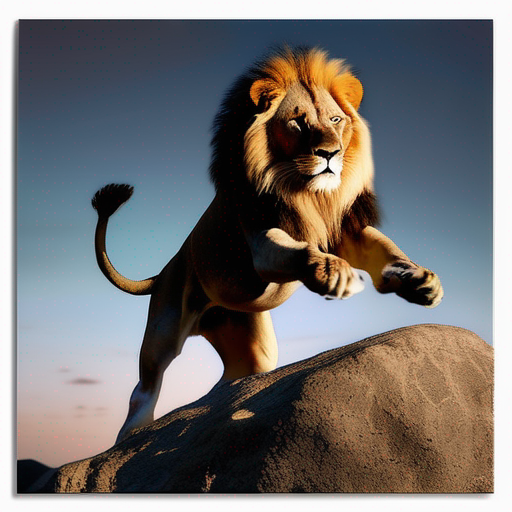

In [ ]:
neg_prompt ="text, watermark,cartoon, anime"
steps=100
sampler="euler"

images = pipe(prompt=prompt,
              negative_prompt=neg_prompt,
              num_inference_steps=steps,height=512, width=512).images[0]
images

Добавим генерацию трех картинок и их вывод

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

  0%|          | 0/100 [00:00<?, ?it/s]

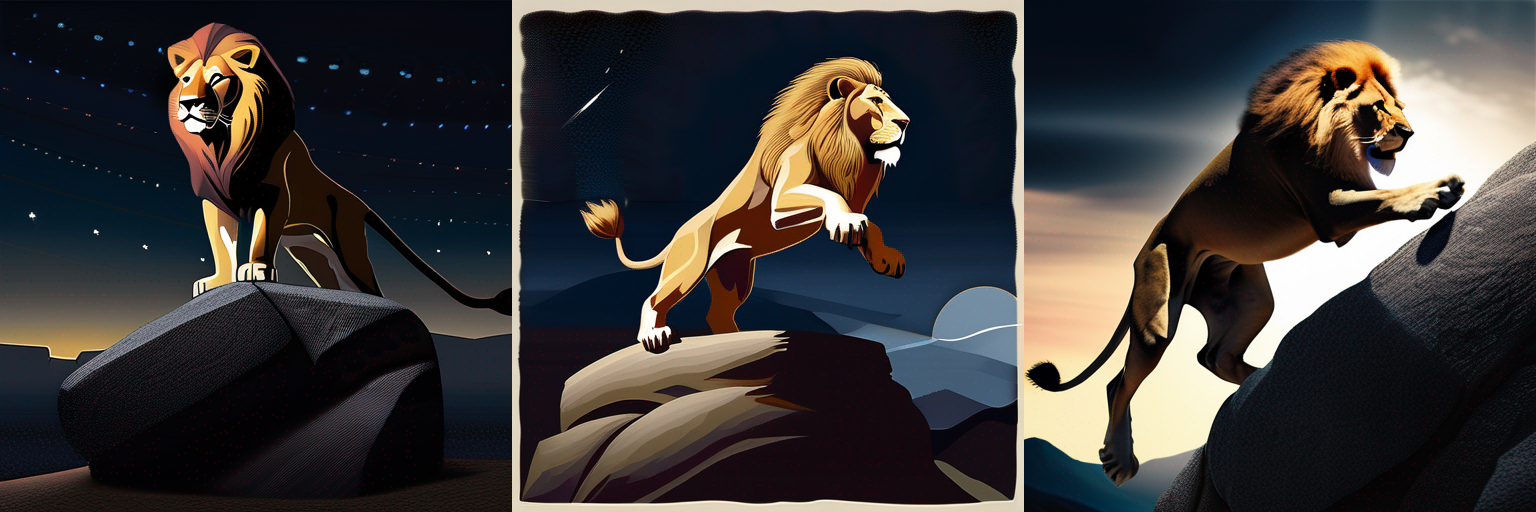

In [ ]:
generator = torch.Generator("cuda").manual_seed(42)
images_num = 3
height = 512
width = 512

images = pipe(prompt, guidance_scale=7.5, generator=generator,negative_prompt=neg_prompt,
              num_inference_steps=steps,height=height, width=width,num_images_per_prompt=images_num)
grid = image_grid(images[0], rows=1, cols=images_num)
grid

Чтобы использовать весь базовый конвейер + уточнение как ансамбль экспертов ![](image/refiner-pipeline.png)
, вы можете запустить:

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, text_encoder_2, tokenizer, tokenizer_2, unet, scheduler to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

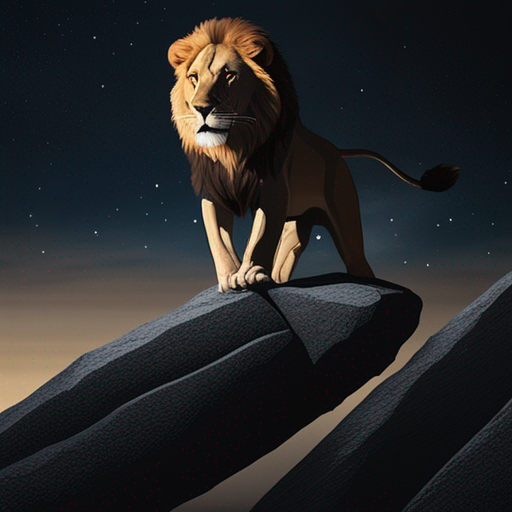

In [3]:
from diffusers import DiffusionPipeline
import torch

# load both base & refiner
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
                                         torch_dtype=torch.float16,
                                         variant="fp16",
                                         use_safetensors=True
)

#pipe.to("cuda")
pipe.enable_model_cpu_offload() #у меня не хватает GPU RAM

refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=pipe.text_encoder_2,
    vae=pipe.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.to("cuda")

# Define how many steps and what % of steps to be run on each experts (80/20) here
n_steps = 40
high_noise_frac = 0.8

prompt = "A majestic lion jumping from a big stone at night"
generator = torch.Generator("cuda").manual_seed(42)
height = 512
width = 512
neg_prompt ="text, watermark,cartoon, anime"
steps=100
sampler="euler"

# run both experts
image = pipe(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    generator=generator,
    negative_prompt=neg_prompt,
    height=height,
    width=width,
    output_type="latent",
).images
image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
).images[0]

image